Learn to predict the number of real solutions of the tritangent circles to three conics.

In [ ]:
#TODO inspect predictions
#TODO check distribution of real counts in training data
#TODO ???

In [ ]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd
import numpy as np

In [ ]:
# Import Data
path = '/Users/las/Documents/GitHub/REU/hill_climb_w_solution_counts.xlsx'
df = pd.read_excel(path)

batch_1 = df[[col for col in df.columns if col[0].isupper()]].rename(str.lower, axis='columns')
batch_2 = df[[col for col in df.columns if col[0].islower()]].rename(str.lower, axis='columns')
batch_2.insert(0, "counts", np.array(batch_1['counts']) - 2)
batch_2[batch_2['counts'] < 0] = 0
data = batch_1.append(batch_2).reset_index().drop('index', axis=1)

In [ ]:
data.sample()

In [ ]:
# Create Training and Validation Data
count = np.array(data['counts'].values.tolist(), dtype=np.int)
param = np.array(data.drop('counts', axis=1).values.tolist(), dtype=np.float64)
n = int(0.95*len(count))

count_train, count_val = count[:n], count[n:]
param_train, param_val = param[:n], param[n:]

In [ ]:
# Set Up Network Architecture
model = keras.Sequential([
    keras.layers.Dense(units=32, activation='relu', input_shape=(18,)),
    keras.layers.Dense(units=64, activation='relu'),    
    keras.layers.Dense(units=96, activation='relu'),
    keras.layers.Dense(units=84, activation='softmax')
])

model.summary()

In [21]:
sce = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='RMSprop', 
              loss=sce,
              metrics=['accuracy', sce])

In [22]:
# Train model
history = model.fit(param_train,
                    count_train,
                    verbose=2,
                    epochs=25,
                    batch_size=64,
                    validation_data=(
                        param_val,
                        count_val
                    )
)

Train on 190000 samples, validate on 10000 samples
Epoch 1/25
190000/190000 - 27s - loss: 2.4648 - accuracy: 0.2046 - sparse_categorical_crossentropy: 2.4648 - val_loss: 2.3407 - val_accuracy: 0.2634 - val_sparse_categorical_crossentropy: 2.3416
Epoch 2/25
190000/190000 - 24s - loss: 2.4481 - accuracy: 0.2089 - sparse_categorical_crossentropy: 2.4481 - val_loss: 2.3422 - val_accuracy: 0.2669 - val_sparse_categorical_crossentropy: 2.3428
Epoch 3/25
190000/190000 - 31s - loss: 2.4364 - accuracy: 0.2138 - sparse_categorical_crossentropy: 2.4364 - val_loss: 2.3493 - val_accuracy: 0.2679 - val_sparse_categorical_crossentropy: 2.3496
Epoch 4/25
190000/190000 - 34s - loss: 2.4304 - accuracy: 0.2168 - sparse_categorical_crossentropy: 2.4304 - val_loss: 2.3243 - val_accuracy: 0.2717 - val_sparse_categorical_crossentropy: 2.3248
Epoch 5/25
190000/190000 - 34s - loss: 2.4261 - accuracy: 0.2194 - sparse_categorical_crossentropy: 2.4261 - val_loss: 2.3472 - val_accuracy: 0.2671 - val_sparse_categor

[]

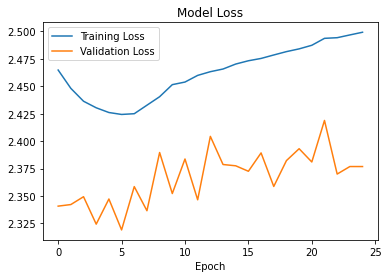

In [23]:
# Graphs
fig = plt.figure()
plt.title('Model Loss')
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.plot()

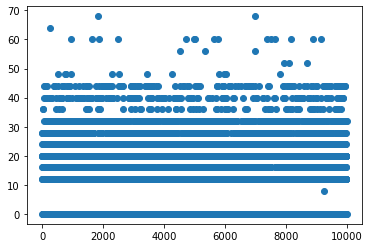

In [34]:
# Inspect Predictions 
fig = plt.figure()
prediction = 2*np.argmax(model.predict(param_val), axis=1)
plt.plot(prediction, 'o')
plt.show()

In [31]:
#print(prediction[:5])
print(len(df[df['counts'] == 0]))

KeyError: 'counts'